In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import re
import random

# NLP
import spacy
from spacy.matcher import PhraseMatcher

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Visualize
import matplotlib.pyplot as plt

In [2]:
# Load dataset
movies_raw = pd.read_csv("movie.csv")
# Make a copy of the original dataset
movies = movies_raw.copy()

# Drop nulls
movies.dropna(subset=["text", "label"], inplace=True)

# Clean function: preserve punctuation, replace HTML tags with periods
def clean_text(text):
    # Replace common HTML tags with sentence-ending punctuation
    text = re.sub(r'<br\s*/?>|<s>|</s>|<p>|</p>|<div>|</div>', '.', text)

    # Remove any other stray tags like <i>, <b>, etc. but preserve punctuation
    text = re.sub(r'<[^>]+>', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

# Apply cleaning
movies["cleaned_text"] = movies["text"].apply(clean_text)

# Show sample cleaned lines
print("Sample cleaned reviews:")
for line in movies["cleaned_text"].sample(5, random_state=42):
    print("-", line)
    print()  # Adds a blank line after each review

Sample cleaned reviews:
- The central theme in this movie seems to be confusion, as the relationships, setting, acting and social context all lead to the same place: confusion. Even Harvey Keitel appears to be out of his element, and lacks his usual impeccable clarity, direction and intensity. To make matters worse, his character's name is 'Che', and we are only told (directly, by the narrator) well into the film that he is not 'that' Che, just a guy named Che. The family relationships remain unclear until the end of the film, and once defined, the family is divided - the younger generation off to America. So cliché. Other reviews discuss how the movie depicts the impact of the revolution on a boy's family; however the political stance of the director is murky at best, and we are never quite sure who is responsible for what bloodshed. So they lost their property (acquired by gambling profits) - so what? Refusing to take a political stand, when making a movie about the Cuban revolution,

### Observation: Data Cleaning
- HTML tags like `<br>` are replaced to preserve sentence boundaries.
- Extra symbols and whitespace are removed to ensure clean input for spaCn.


In [3]:
# Load Spacy model
nlp = spacy.load("en_core_web_sm")

# Optional idiomatic negation phrases
negation_phrases = ["could care less", "hardly a", "barely worth", "no way", "not a chance"]
matcher = PhraseMatcher(nlp.vocab)
matcher.add("NEG_IDIOM", [nlp.make_doc(phrase) for phrase in negation_phrases])

def preprocess_text(text, lemmatize_words=True, remove_stop_words=True, handle_logical_negation=True):
    doc = nlp(text)
    tokens = []
    
    # Detect idiomatic negation
    idiom_matches = set()
    for _, start, end in matcher(doc):
        idiom_matches.update(range(start, end))

    for i, token in enumerate(doc):
        # Skip idiomatic phrases 
        if i in idiom_matches:
            continue

        # Handle logical negation
        if handle_logical_negation and token.dep_ == "neg":
            head = token.head
            tokens.append(token.text)
            tokens.append("NOT_" + head.lemma_)
            continue

        # Lemmatize
        word = token.lemma_ if lemmatize_words else token.text

        # Remove stop words
        if remove_stop_words and token.is_stop:
            continue

        tokens.append(word)

    return " ".join(tokens)

In [4]:
# Sample 1000 reviews for training
train_data = movies.sample(n=1000, random_state=1)

# From remaining, sample 100 reviews per class for testing
remaining = movies.drop(train_data.index)
test_data_class_0 = remaining[remaining["label"] == 0].sample(n=100, random_state=2)
test_data_class_1 = remaining[remaining["label"] == 1].sample(n=100, random_state=3)
test_data = pd.concat([test_data_class_0, test_data_class_1]).sample(frac=1, random_state=4)  # shuffle

# Apply preprocessing to both sets
train_data["processed_text"] = train_data["cleaned_text"].apply(
    lambda x: preprocess_text(x, lemmatize_words=True, remove_stop_words=True, handle_logical_negation=True)
)

test_data["processed_text"] = test_data["cleaned_text"].apply(
    lambda x: preprocess_text(x, lemmatize_words=True, remove_stop_words=True, handle_logical_negation=True)
)

# Show sample processed lines
print("Sample processed training reviews:")
for line in train_data["processed_text"].sample(5, random_state=42):
    print("-", line)
    print()

Sample processed training reviews:
- having hear Modesty Blaise , never NOT_read having read novel comic strip , wife like film lot . deliver , captivating way , good introduction character background ... action flick element , intimate play , excellently write . sadly , , major drawback movie reveal . intimate play life capability actor unfortunately half cast deliver . Alexandra Staden excellent job Modesty Blaise , counterpart Nikolaj Coaster - Waldau - villain Miklos - not NOT_do . smile way plot extend toothpaste commercial , fail build atmosphere anxiety movie masterpiece . support cast similar , stereotype gangster slut decent performance Fred Pearson Professor Lob Eugenia Yuan Irina .

- brief history time . cosmological content documentary fascinating , thought provoke man ... brilliant . hard time enjoy documentary . .. way family member professor interview feel unnatural . member interview specifically build set direct uncomfortably . , account come acted forcefully direct .

In [5]:
def build_vocabulary_and_counts(data, labels):
    vocab = set()
    word_counts = {0: {}, 1: {}}
    class_totals = {0: 0, 1: 0}

    for text, label in zip(data, labels):
        words = text.split()
        for word in words:
            vocab.add(word)
            word_counts[label][word] = word_counts[label].get(word, 0) + 1
            class_totals[label] += 1

    return sorted(vocab), word_counts, class_totals

In [6]:
# Build vocabulary and word counts from training data
vocab, word_counts, class_totals = build_vocabulary_and_counts(
    train_data["processed_text"], train_data["label"]
)

print(f"Vocabulary size: {len(vocab)}")
print("Sample vocabulary:", vocab[:10])

Vocabulary size: 17254
Sample vocabulary: ['!', '"', '"A', '"Beirut', '"Contra', '"Gimme', '"I', '"K2', '"Kriemhild', '"The']


In [7]:
def train_naive_bayes(vocab, word_counts, class_totals):
    prior = {}
    likelihood = {0: {}, 1: {}}
    V = len(vocab)

    # Compute priors
    total_docs = sum(class_totals.values())
    for cls in [0, 1]:
        prior[cls] = np.log(class_totals[cls] / total_docs)

    # Compute likelihoods with Laplace smoothing
    for cls in [0, 1]:
        for word in vocab:
            count = word_counts[cls].get(word, 0)
            likelihood[cls][word] = np.log((count + 1) / (class_totals[cls] + V))

    return prior, likelihood

In [8]:
# Train Naïve Bayes model
prior, likelihood = train_naive_bayes(vocab, word_counts, class_totals)

# Show sample log-likelihoods
print("Sample log-likelihoods for class 0:")
for word in vocab[:5]:
    print(f"{word}: {likelihood[0][word]:.4f}")

Sample log-likelihoods for class 0:
!: -5.1950
": -4.1706
"A: -11.3976
"Beirut: -11.3976
"Contra: -10.7044


In [9]:
def predict_naive_bayes(texts, prior, likelihood, vocab):
    predictions = []

    for text in texts:
        words = text.split()
        scores = {0: prior[0], 1: prior[1]}

        for cls in [0, 1]:
            for word in words:
                if word in vocab:
                    scores[cls] += likelihood[cls].get(word, 0)
                else:
                    continue  # Unknown word: skip or treat as space

        predicted_label = 0 if scores[0] > scores[1] else 1
        predictions.append(predicted_label)

    return predictions

In [10]:
# Predict on test data
test_predictions = predict_naive_bayes(
    test_data["processed_text"], prior, likelihood, vocab
)

# Store predictions
test_data["predicted_label"] = test_predictions

# Show sample predictions
print("Sample predictions:")
print(test_data[["label", "predicted_label"]].sample(10, random_state=42))

Sample predictions:
       label  predicted_label
2533       1                1
21650      1                1
32954      0                0
13828      1                1
15884      0                0
3917       1                1
33137      0                0
7732       0                0
8286       1                1
6571       0                0


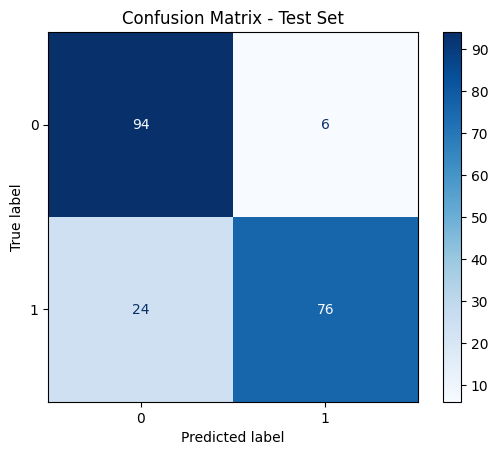

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(test_data["label"], test_data["predicted_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

In [12]:
# Diagnostic test sentence
example_sentence = "I could care less about this movie. Not only was it boring, but also confusing. Meh."

# Clean and preprocess
cleaned_example = clean_text(example_sentence)
processed_example = preprocess_text(cleaned_example, lemmatize_words=True, remove_stop_words=True, handle_logical_negation=True)

# Predict
example_prediction = predict_naive_bayes([processed_example], prior, likelihood, vocab)[0]

print("Diagnostic example:")
print("Original:", example_sentence)
print("Processed:", processed_example)
print("Predicted label:", example_prediction)
print()

Diagnostic example:
Original: I could care less about this movie. Not only was it boring, but also confusing. Meh.
Processed: movie . boring , confusing . Meh .
Predicted label: 0



In [13]:
def run_experiment(run_id, lemmatize, remove_stop, handle_negation):
    print(f"\n--- Run {run_id}: Lemmatize={lemmatize}, StopWords={remove_stop}, Negation={handle_negation} ---")

    # Preprocess training and test sets
    train_processed = train_data["cleaned_text"].apply(
        lambda x: preprocess_text(x, lemmatize, remove_stop, handle_negation)
    )
    test_processed = test_data["cleaned_text"].apply(
        lambda x: preprocess_text(x, lemmatize, remove_stop, handle_negation)
    )

    # Build vocab and train
    vocab, word_counts, class_totals = build_vocabulary_and_counts(train_processed, train_data["label"])
    prior, likelihood = train_naive_bayes(vocab, word_counts, class_totals)

    # Predict
    predictions = predict_naive_bayes(test_processed, prior, likelihood, vocab)

    # Evaluate
    y_true = test_data["label"].tolist()
    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, average=None)
    recall = recall_score(y_true, predictions, average=None)
    f1 = f1_score(y_true, predictions, average=None)
    micro_f1 = f1_score(y_true, predictions, average="micro")
    macro_f1 = f1_score(y_true, predictions, average="macro")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (class 0): {precision[0]:.4f}, Precision (class 1): {precision[1]:.4f}")
    print(f"Recall    (class 0): {recall[0]:.4f}, Recall    (class 1): {recall[1]:.4f}")
    print(f"F1 Score  (class 0): {f1[0]:.4f}, F1 Score  (class 1): {f1[1]:.4f}")
    print(f"Micro F1: {micro_f1:.4f}, Macro F1: {macro_f1:.4f}")

    return {
        "run": run_id,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "micro_f1": micro_f1,
        "macro_f1": macro_f1
    }

In [14]:
# Run all four experiments
results = []

results.append(run_experiment(1, lemmatize=False, remove_stop=False, handle_negation=False))
results.append(run_experiment(2, lemmatize=True,  remove_stop=False, handle_negation=False))
results.append(run_experiment(3, lemmatize=True,  remove_stop=True,  handle_negation=False))
results.append(run_experiment(4, lemmatize=True,  remove_stop=True,  handle_negation=True))


--- Run 1: Lemmatize=False, StopWords=False, Negation=False ---
Accuracy: 0.8500
Precision (class 0): 0.8125, Precision (class 1): 0.8977
Recall    (class 0): 0.9100, Recall    (class 1): 0.7900
F1 Score  (class 0): 0.8585, F1 Score  (class 1): 0.8404
Micro F1: 0.8500, Macro F1: 0.8495

--- Run 2: Lemmatize=True, StopWords=False, Negation=False ---
Accuracy: 0.8400
Precision (class 0): 0.7881, Precision (class 1): 0.9146
Recall    (class 0): 0.9300, Recall    (class 1): 0.7500
F1 Score  (class 0): 0.8532, F1 Score  (class 1): 0.8242
Micro F1: 0.8400, Macro F1: 0.8387

--- Run 3: Lemmatize=True, StopWords=True, Negation=False ---
Accuracy: 0.8400
Precision (class 0): 0.7931, Precision (class 1): 0.9048
Recall    (class 0): 0.9200, Recall    (class 1): 0.7600
F1 Score  (class 0): 0.8519, F1 Score  (class 1): 0.8261
Micro F1: 0.8400, Macro F1: 0.8390

--- Run 4: Lemmatize=True, StopWords=True, Negation=True ---
Accuracy: 0.8500
Precision (class 0): 0.7966, Precision (class 1): 0.9268
Rec

In [15]:
# Diagnostic sentence
example_sentence = "I couldn’t care less about this movie. It was not only boring but also painfully slow. Meh."

# Define all four configurations
configs = [
    {"run": 1, "lemmatize": False, "remove_stop": False, "handle_negation": False},
    {"run": 2, "lemmatize": True,  "remove_stop": False, "handle_negation": False},
    {"run": 3, "lemmatize": True,  "remove_stop": True,  "handle_negation": False},
    {"run": 4, "lemmatize": True,  "remove_stop": True,  "handle_negation": True}
]

# Run diagnostic across all configurations
for cfg in configs:
    processed = preprocess_text(
        clean_text(example_sentence),
        lemmatize_words=cfg["lemmatize"],
        remove_stop_words=cfg["remove_stop"],
        handle_logical_negation=cfg["handle_negation"]
    )
    prediction = predict_naive_bayes([processed], prior, likelihood, vocab)[0]
    print(f"Run {cfg['run']} | Lemmatize={cfg['lemmatize']} | StopWords={cfg['remove_stop']} | Negation={cfg['handle_negation']}")
    print("Processed:", processed)
    print("Predicted Label:", prediction)
    print("-" * 80)

Run 1 | Lemmatize=False | StopWords=False | Negation=False
Processed: I could n’t care less about this movie . It was not only boring but also painfully slow . Meh .
Predicted Label: 0
--------------------------------------------------------------------------------
Run 2 | Lemmatize=True | StopWords=False | Negation=False
Processed: I could not care less about this movie . it be not only boring but also painfully slow . Meh .
Predicted Label: 0
--------------------------------------------------------------------------------
Run 3 | Lemmatize=True | StopWords=True | Negation=False
Processed: care movie . boring painfully slow . Meh .
Predicted Label: 0
--------------------------------------------------------------------------------
Run 4 | Lemmatize=True | StopWords=True | Negation=True
Processed: n’t NOT_care care movie . boring painfully slow . Meh .
Predicted Label: 0
--------------------------------------------------------------------------------


In [16]:
# Build comparison table
comparison = pd.DataFrame([
    {
        "Run": r["run"],
        "Lemmatization": ["No", "Yes", "Yes", "Yes"][r["run"] - 1],
        "Stop Words": ["No", "No", "Yes", "Yes"][r["run"] - 1],
        "Negation": ["No", "No", "No", "Yes"][r["run"] - 1],
        "Accuracy": f"{r['accuracy']:.4f}",
        "Precision_0": f"{r['precision'][0]:.4f}",
        "Recall_0": f"{r['recall'][0]:.4f}",
        "F1_0": f"{r['f1'][0]:.4f}",
        "Precision_1": f"{r['precision'][1]:.4f}",
        "Recall_1": f"{r['recall'][1]:.4f}",
        "F1_1": f"{r['f1'][1]:.4f}",
        "Micro_F1": f"{r['micro_f1']:.4f}",
        "Macro_F1": f"{r['macro_f1']:.4f}"
    }
    for r in results
])

# Display table
print("Comparison of all four runs:")
print(comparison.to_string(index=False))

Comparison of all four runs:
 Run Lemmatization Stop Words Negation Accuracy Precision_0 Recall_0   F1_0 Precision_1 Recall_1   F1_1 Micro_F1 Macro_F1
   1            No         No       No   0.8500      0.8125   0.9100 0.8585      0.8977   0.7900 0.8404   0.8500   0.8495
   2           Yes         No       No   0.8400      0.7881   0.9300 0.8532      0.9146   0.7500 0.8242   0.8400   0.8387
   3           Yes        Yes       No   0.8400      0.7931   0.9200 0.8519      0.9048   0.7600 0.8261   0.8400   0.8390
   4           Yes        Yes      Yes   0.8500      0.7966   0.9400 0.8624      0.9268   0.7600 0.8352   0.8500   0.8488


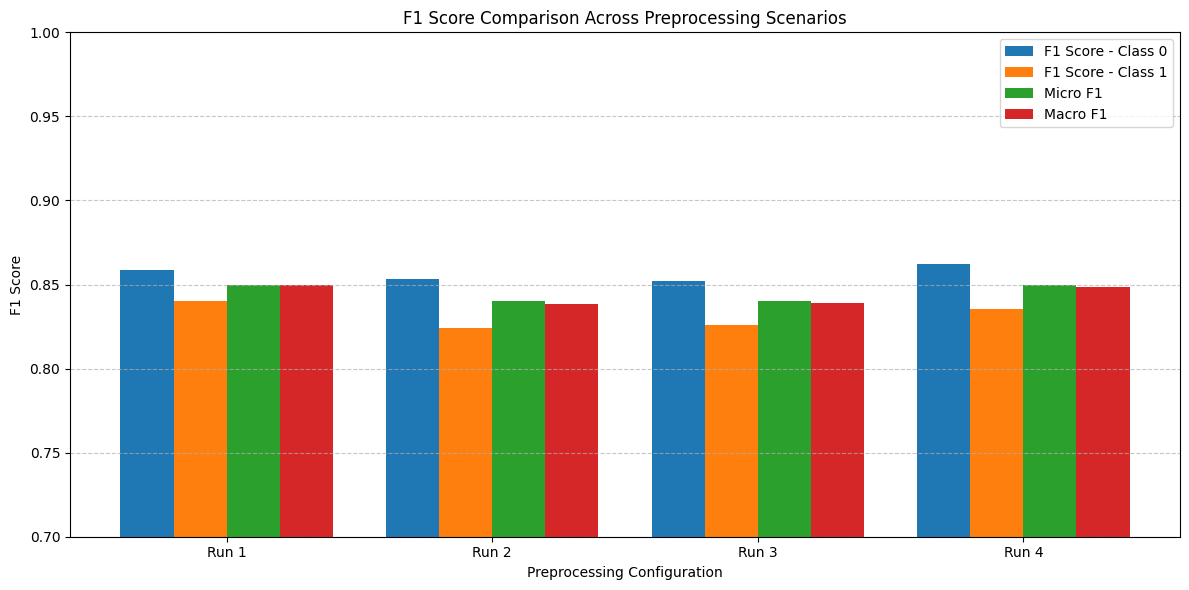

In [17]:
# Prepare data
runs = [f"Run {r['run']}" for r in results]
f1_class_0 = [r["f1"][0] for r in results]
f1_class_1 = [r["f1"][1] for r in results]
micro_f1 = [r["micro_f1"] for r in results]
macro_f1 = [r["macro_f1"] for r in results]

# Bar chart setup
x = np.arange(len(runs))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, f1_class_0, width, label='F1 Score - Class 0')
plt.bar(x - 0.5*width, f1_class_1, width, label='F1 Score - Class 1')
plt.bar(x + 0.5*width, micro_f1, width, label='Micro F1')
plt.bar(x + 1.5*width, macro_f1, width, label='Macro F1')

# Labels and formatting
plt.xticks(x, runs)
plt.xlabel("Preprocessing Configuration")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison Across Preprocessing Scenarios")
plt.ylim(0.7, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
def extract_unigrams_and_bigrams(text):
    words = text.split()
    bigrams = [f"{words[i]}_{words[i+1]}" for i in range(len(words) - 1)]
    return words + bigrams

In [19]:
def build_vocabulary_and_counts_bigram(data, labels):
    vocab = set()
    word_counts = {0: {}, 1: {}}
    class_totals = {0: 0, 1: 0}

    for text, label in zip(data, labels):
        tokens = extract_unigrams_and_bigrams(text)
        for token in tokens:
            vocab.add(token)
            word_counts[label][token] = word_counts[label].get(token, 0) + 1
            class_totals[label] += 1

    return sorted(vocab), word_counts, class_totals

In [20]:
def predict_naive_bayes_bigram(texts, prior, likelihood, vocab):
    predictions = []

    for text in texts:
        tokens = extract_unigrams_and_bigrams(text)
        scores = {0: prior[0], 1: prior[1]}

        for cls in [0, 1]:
            for token in tokens:
                if token in vocab:
                    scores[cls] += likelihood[cls].get(token, 0)

        predicted_label = 0 if scores[0] > scores[1] else 1
        predictions.append(predicted_label)

    return predictions

In [21]:
# Preprocess using best config (Run 4)
train_processed_bigram = train_data["cleaned_text"].apply(
    lambda x: preprocess_text(x, lemmatize_words=True, remove_stop_words=True, handle_logical_negation=True)
)
test_processed_bigram = test_data["cleaned_text"].apply(
    lambda x: preprocess_text(x, lemmatize_words=True, remove_stop_words=True, handle_logical_negation=True)
)

# Train and predict using bigrams
vocab_bi, word_counts_bi, class_totals_bi = build_vocabulary_and_counts_bigram(train_processed_bigram, train_data["label"])
prior_bi, likelihood_bi = train_naive_bayes(vocab_bi, word_counts_bi, class_totals_bi)
predictions_bi = predict_naive_bayes_bigram(test_processed_bigram, prior_bi, likelihood_bi, vocab_bi)

# Evaluate
y_true = test_data["label"].tolist()
accuracy_bi = accuracy_score(y_true, predictions_bi)
precision_bi = precision_score(y_true, predictions_bi, average=None)
recall_bi = recall_score(y_true, predictions_bi, average=None)
f1_bi = f1_score(y_true, predictions_bi, average=None)
micro_f1_bi = f1_score(y_true, predictions_bi, average="micro")
macro_f1_bi = f1_score(y_true, predictions_bi, average="macro")

In [22]:
print("\n Comparison: Unigram vs Bigram (Run 4 vs Bigram)")
print(f"Accuracy:     Unigram={results[3]['accuracy']:.4f} | Bigram={accuracy_bi:.4f}")
print(f"Precision 0:  Unigram={results[3]['precision'][0]:.4f} | Bigram={precision_bi[0]:.4f}")
print(f"Recall    0:  Unigram={results[3]['recall'][0]:.4f}    | Bigram={recall_bi[0]:.4f}")
print(f"F1 Score  0:  Unigram={results[3]['f1'][0]:.4f}        | Bigram={f1_bi[0]:.4f}")
print(f"Precision 1:  Unigram={results[3]['precision'][1]:.4f} | Bigram={precision_bi[1]:.4f}")
print(f"Recall    1:  Unigram={results[3]['recall'][1]:.4f}    | Bigram={recall_bi[1]:.4f}")
print(f"F1 Score  1:  Unigram={results[3]['f1'][1]:.4f}        | Bigram={f1_bi[1]:.4f}")
print(f"Micro F1:     Unigram={results[3]['micro_f1']:.4f}    | Bigram={micro_f1_bi:.4f}")
print(f"Macro F1:     Unigram={results[3]['macro_f1']:.4f}    | Bigram={macro_f1_bi:.4f}")


 Comparison: Unigram vs Bigram (Run 4 vs Bigram)
Accuracy:     Unigram=0.8500 | Bigram=0.8500
Precision 0:  Unigram=0.7966 | Bigram=0.7917
Recall    0:  Unigram=0.9400    | Bigram=0.9500
F1 Score  0:  Unigram=0.8624        | Bigram=0.8636
Precision 1:  Unigram=0.9268 | Bigram=0.9375
Recall    1:  Unigram=0.7600    | Bigram=0.7500
F1 Score  1:  Unigram=0.8352        | Bigram=0.8333
Micro F1:     Unigram=0.8500    | Bigram=0.8500
Macro F1:     Unigram=0.8488    | Bigram=0.8485


In [23]:
def run_bigram_experiment(run_id, lemmatize, remove_stop, handle_negation):
    print(f"\n--- Bigram Run {run_id}: Lemmatize={lemmatize}, StopWords={remove_stop}, Negation={handle_negation} ---")

    # Preprocess training and test sets
    train_processed = train_data["cleaned_text"].apply(
        lambda x: preprocess_text(x, lemmatize, remove_stop, handle_negation)
    )
    test_processed = test_data["cleaned_text"].apply(
        lambda x: preprocess_text(x, lemmatize, remove_stop, handle_negation)
    )

    # Build vocab and train using bigrams
    vocab, word_counts, class_totals = build_vocabulary_and_counts_bigram(train_processed, train_data["label"])
    prior, likelihood = train_naive_bayes(vocab, word_counts, class_totals)

    # Predict using bigrams
    predictions = predict_naive_bayes_bigram(test_processed, prior, likelihood, vocab)

    # Evaluate
    y_true = test_data["label"].tolist()
    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, average=None)
    recall = recall_score(y_true, predictions, average=None)
    f1 = f1_score(y_true, predictions, average=None)
    micro_f1 = f1_score(y_true, predictions, average="micro")
    macro_f1 = f1_score(y_true, predictions, average="macro")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (class 0): {precision[0]:.4f}, Precision (class 1): {precision[1]:.4f}")
    print(f"Recall    (class 0): {recall[0]:.4f}, Recall    (class 1): {recall[1]:.4f}")
    print(f"F1 Score  (class 0): {f1[0]:.4f}, F1 Score  (class 1): {f1[1]:.4f}")
    print(f"Micro F1: {micro_f1:.4f}, Macro F1: {macro_f1:.4f}")

    return {
        "run": run_id,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "micro_f1": micro_f1,
        "macro_f1": macro_f1
    }

In [24]:
# Run bigram experiments
bigram_results = []
for i, cfg in enumerate([
    {"lemmatize": False, "remove_stop": False, "handle_negation": False},
    {"lemmatize": True,  "remove_stop": False, "handle_negation": False},
    {"lemmatize": True,  "remove_stop": True,  "handle_negation": False},
    {"lemmatize": True,  "remove_stop": True,  "handle_negation": True}
]):
    bigram_results.append(run_bigram_experiment(i + 1, **cfg))


--- Bigram Run 1: Lemmatize=False, StopWords=False, Negation=False ---
Accuracy: 0.8150
Precision (class 0): 0.7603, Precision (class 1): 0.8987
Recall    (class 0): 0.9200, Recall    (class 1): 0.7100
F1 Score  (class 0): 0.8326, F1 Score  (class 1): 0.7933
Micro F1: 0.8150, Macro F1: 0.8129

--- Bigram Run 2: Lemmatize=True, StopWords=False, Negation=False ---
Accuracy: 0.7950
Precision (class 0): 0.7287, Precision (class 1): 0.9155
Recall    (class 0): 0.9400, Recall    (class 1): 0.6500
F1 Score  (class 0): 0.8210, F1 Score  (class 1): 0.7602
Micro F1: 0.7950, Macro F1: 0.7906

--- Bigram Run 3: Lemmatize=True, StopWords=True, Negation=False ---
Accuracy: 0.8350
Precision (class 0): 0.7815, Precision (class 1): 0.9136
Recall    (class 0): 0.9300, Recall    (class 1): 0.7400
F1 Score  (class 0): 0.8493, F1 Score  (class 1): 0.8177
Micro F1: 0.8350, Macro F1: 0.8335

--- Bigram Run 4: Lemmatize=True, StopWords=True, Negation=True ---
Accuracy: 0.8500
Precision (class 0): 0.7917, Pre

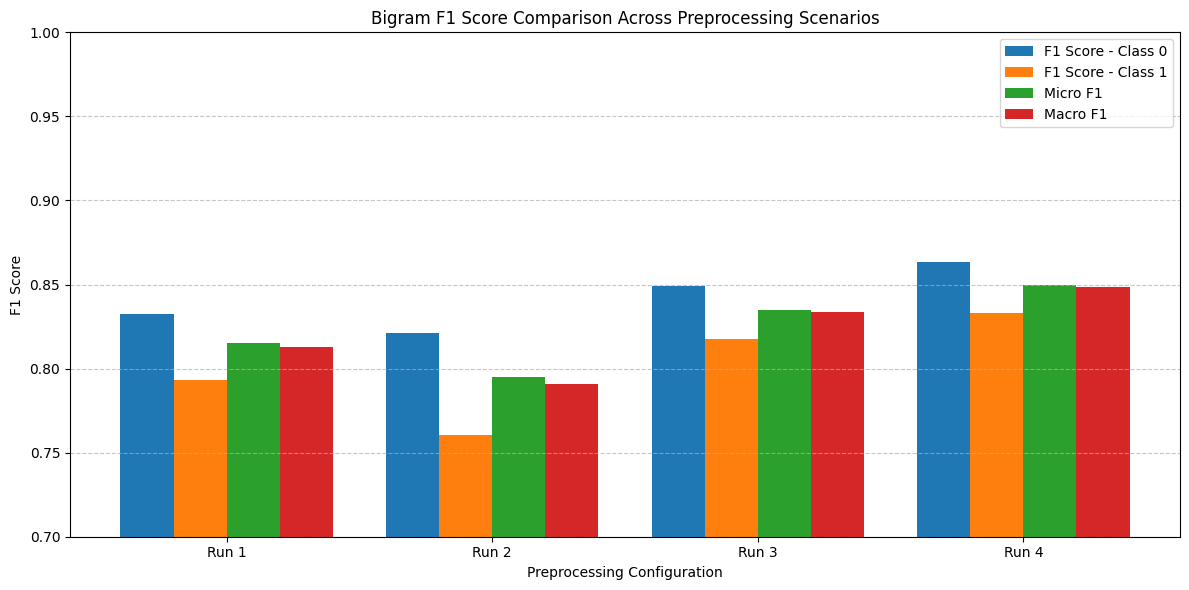

In [25]:
# Prepare data
runs = [f"Run {r['run']}" for r in bigram_results]
f1_class_0 = [r["f1"][0] for r in bigram_results]
f1_class_1 = [r["f1"][1] for r in bigram_results]
micro_f1 = [r["micro_f1"] for r in bigram_results]
macro_f1 = [r["macro_f1"] for r in bigram_results]

# Bar chart setup
x = np.arange(len(runs))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, f1_class_0, width, label='F1 Score - Class 0')
plt.bar(x - 0.5*width, f1_class_1, width, label='F1 Score - Class 1')
plt.bar(x + 0.5*width, micro_f1, width, label='Micro F1')
plt.bar(x + 1.5*width, macro_f1, width, label='Macro F1')

# Labels and formatting
plt.xticks(x, runs)
plt.xlabel("Preprocessing Configuration")
plt.ylabel("F1 Score")
plt.title("Bigram F1 Score Comparison Across Preprocessing Scenarios")
plt.ylim(0.7, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
import nbformat

# Load the notebook
with open("Mondal_HW1.ipynb", "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Access all cells
all_cells = nb.cells

# Print cell types and content
for i, cell in enumerate(all_cells):
    print(f"\n--- Cell {i+1} ({cell.cell_type}) ---")
    print(cell.source)


--- Cell 1 (code) ---
# Importing libraries
import pandas as pd
import numpy as np
import re
import random

# NLP
import spacy
from spacy.matcher import PhraseMatcher

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Visualize
import matplotlib.pyplot as plt

--- Cell 2 (code) ---
# Load dataset
movies_raw = pd.read_csv("movie.csv")
# Make a copy of the original dataset
movies = movies_raw.copy()

# Drop nulls
movies.dropna(subset=["text", "label"], inplace=True)

# Clean function: preserve punctuation, replace HTML tags with periods
def clean_text(text):
    # Replace common HTML tags with sentence-ending punctuation
    text = re.sub(r'<br\s*/?>|<s>|</s>|<p>|</p>|<div>|</div>', '.', text)

    # Remove any other stray tags like <i>, <b>, etc. but preserve punctuation
    text = re.sub(r'<[^>]+>', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

# Apply cleaning
movies["cleaned_text"